In [ ]:
from sklearn.model_selection import KFold

def model_pred(model, data, kagg, y, ykagg=np.array([]), params=None):
    # data - весь трейн в пандасе/ нумпай массиве / csr матрице
    # kagg - весь тест в пандасе/ нумпай массиве / csr матрице
    # y - таргет для всего трейна в пандас сериес или нумпай массиве
    # params - параметры (см. пример)
    
    if type(data).__name__=='DataFrame':
        data = data.values
    if type(kagg).__name__=='DataFrame':
        kagg = kagg.values
    if type(y).__name__=='Series' or type(y).__name__=='DataFrame':
        y = y.values
        
    if model == 'fastfm' and type(data).__name__ != 'csr_matrix':
        data = csr_matrix(data)
        kagg = csr_matrix(kagg)
    if model == 'fastfm':
        y = y.replace(0,-1)
        
    scores=[]
    #  prediction matrices
    data_out = np.zeros((data.shape[0]))
    kagg_out = np.zeros((kagg.shape[0]))
    
    n_splits = 5
    iters_total = 2
    ids = pd.read_csv('data/final/data_ids.csv',usecols=['graph_id'])
    graph_ids_unique = ids.graph_id.unique() # array of unique graphs
    
    for iter_num in range(iters_total):
        kf = KFold(n_splits=n_splits, shuffle=True)
        for train_graphs, test_graphs  in kf.split(graph_ids_unique):
            train_ind = ids[ids.graph_id.isin(graph_ids_unique[train_graphs])].index.values
            test_ind  = ids[ids.graph_id.isin(graph_ids_unique[test_graphs ])].index.values
            
            if model=='xgb' or model=='lgb' or model=='nnet': # add validation set
                kf_valid = KFold(n_splits=8, shuffle=True)
                graph_ids_train = graph_ids_unique[train_graphs]
                train_graphs, valid_graphs = list(kf_valid.split(graph_ids_train))[0]
                train_ind = ids[ids.graph_id.isin(graph_ids_train[train_graphs])].index.values
                valid_ind = ids[ids.graph_id.isin(graph_ids_train[valid_graphs])].index.values 
                
            if model=='lgb':
                fold_pred, kagg_pred = lgb_pred (params, data[train_ind], y[train_ind], 
                                                         data[valid_ind], y[valid_ind],
                                                         data[test_ind], kagg)
            elif model=='xgb':
                fold_pred, kagg_pred = xgb_pred (params, data[train_ind], y[train_ind], 
                                                         data[valid_ind], y[valid_ind],
                                                         data[test_ind], kagg)
            elif model=='nnet':
                fold_pred, kagg_pred = nnet_pred(params, data[train_ind], y[train_ind], 
                                                         data[valid_ind], y[valid_ind],
                                                         data[test_ind], kagg)
            elif model=='fastfm':
                fold_pred, kagg_pred = fastfm_pred(params, data[train_ind], y[train_ind], data[test_ind], kagg)
                
            else:
                model.fit(train, ytrain)
                try:
                    fold_pred = model.predict_proba(test)[:,1]
                    kagg_pred = model.predict_proba(kagg)[:,1]
                except:
                    try:
                        fold_pred = model.predict_proba(test)
                        kagg_pred = model.predict_proba(kagg)
                    except:
                        fold_pred = model.predict(test)
                        kagg_pred = model.predict(kagg)
                    
            data_out[test_ind] += fold_pred
            kagg_out += kagg_pred
            if iter_num==0:
                #print (log_loss(ytest, fold_pred))
                print (log_loss(y[test_ind], fold_pred))
            
        if ykagg.shape[0]>0:
            print ('kagg score:', log_loss(ykagg, kagg_out/(iter_num+1)/n_splits))
        print ('train score:', log_loss(y, data_out/(iter_num+1)))
    data_out /= iters_total
    kagg_out /= (iters_total*n_splits)
    return data_out, kagg_out

In [ ]:
train_2['lgb_oof'], test_2['lgb_oof'] = model_pred('lgb', 
                                                    train[num_features], 
                                                    test [num_features], 
                                                    ytrain, params=params)

## Мусор

In [1]:
import pandas as pd
t1 = pd.read_csv('subs/lgb_oof_325_CV24265_WITH_correctSplits_pos_tags.csv',usecols=['is_duplicate'])

In [3]:
t1['old'] = pd.read_csv('subs/lgb_oof_307_CV1771_WITH_feat236_stem_locs_tfidfoof_FMoof_lenfm_magicCorrected_NO_tfidf_FM_oofs.csv',usecols=['is_duplicate'])

In [5]:
YTrain = pd.read_csv(INPUT_FOLDER + '/train.csv', usecols=['is_duplicate']).values.ravel()

ids = pd.read_csv('data/final/data_ids.csv',usecols=['graph_id'])
graph_ids_unique = ids.graph_id.unique()

with open('dump_sequences.pkl', 'rb') as f:
    x1_train, x2_train, x1_test, x2_test, nb_words = pickle.load(f)
embedding_matrix = np.load('embedding_matrix.npy')



print x1_train.shape, x2_train.shape
print x1_test.shape, x2_test.shape
print nb_words

N_FOLDS = 5
N_ITER = 3

print "Creating train and test sets for blending."
preds_train = np.zeros((x1_train.shape[0]))
preds_test_j = np.zeros((x1_test.shape[0]))
loglosses = []

from sklearn.model_selection import KFold

for iter_num in range(N_ITER):
    kf = KFold(n_splits=n_splits, shuffle=True)
    splits = list(kf.split(graph_ids_unique))

    for fold_id, (train_graphs, test_graphs) in enumerate(splits):
        print "Fold", fold_id
        train_ind = ids[ids.graph_id.isin(graph_ids_unique[train_graphs])].index.values # temporary train indexes
        test_ind  = ids[ids.graph_id.isin(graph_ids_unique[test_graphs ])].index.values # final test indexes
        
        kf_valid = KFold(n_splits=8)
        graph_ids_train = graph_ids_unique[train_graphs]
        train_graphs, valid_graphs = list(kf_valid.split(graph_ids_train))[0]
        train_ind = ids[ids.graph_id.isin(graph_ids_train[train_graphs])].index.values # final train indexes
        valid_ind = ids[ids.graph_id.isin(graph_ids_train[valid_graphs])].index.values # final valid indexes
        

        clf = KerasConvnet()
        clf.fit(x1_train[train_ind], x2_train[train_ind], YTrain[train_ind],
                x1_train[valid_ind], x2_train[valid_ind], YTrain[valid_ind])

        y_pred = clf.predict(x1_train[test_ind], x2_train[test_ind])
        preds_train[test_ind] += y_pred

        lloss = log_loss(YTrain[test_ind], y_pred)
        loglosses.append(lloss)
        print 'LogLoss: ', lloss

        # Predict on entire test set
        preds_test_j += clf.predict(x1_test, x2_test).ravel()

    print "Out of fold logloss-es:\n", loglosses
    print 'train score:', log_loss(YTrain, preds_train / (iter_num + 1))


,is_duplicate,old
is_duplicate,1.00000,0.98773
old,0.98773,1.00000


In [43]:
t = pd.DataFrame()
t['1313'] = pd.read_csv('subs/lgb_oof_324_CV1767_WITH_correctSplits_pos.csv', usecols=['is_duplicate'])
t['12758'] = pd.read_csv('subs/lgb_oof_311_WITH_feat236_stem_locs_tfidfoof_FMoof_lenfm_magicCorrected_CV1746.csv', usecols=['is_duplicate'])
t['1313'].mean(), t['12758'].mean()

(0.08537451907256936, 0.08620366919042675)

In [44]:
t = pd.DataFrame()
t['1313'] = pd.read_csv('subs/data_lgb_oof_324_CV1767_WITH_correctSplits_pos.csv', usecols=['lgb_oof_324_CV1767_WITH_correctSplits_pos'])
t['12758'] = pd.read_csv('subs/data_lgb_oof_311_WITH_feat236_stem_locs_tfidfoof_FMoof_lenfm_magicCorrected_CV1746.csv', usecols=['lgb_oof_311_WITH_feat236_stem_locs_tfidfoof_FMoof_lenfm_magicCorrected_CV1746'])
t['1313'].mean(), t['12758'].mean()

(0.3675672312058731, 0.3681929089369834)

In [22]:
t = pd.read_csv('subs/kagg_lgb_oof_324_CV1767_WITH_correctSplits_pos.csv', usecols=['is_duplicate'])
t['12755'] = pd.read_csv('subs/kagg_lgb_oof_325_CV24265_WITH_correctSplits_pos_tags.csv', usecols=['is_duplicate'])
t['12758'] = pd.read_csv('subs/kagg_lgb_oof_311_WITH_feat236_stem_locs_tfidfoof_FMoof_lenfm_magicCorrected_CV1746.csv', usecols=['is_duplicate'])

In [45]:
t = pd.DataFrame()
t['new'] = pd.read_csv('subs/lgb_oof_324_CV1759_WITH_correctSplits_pos.csv', usecols=['is_duplicate'])
t['1313'] = pd.read_csv('subs/lgb_oof_324_CV1767_WITH_correctSplits_pos.csv', usecols=['is_duplicate'])
t['12755'] = pd.read_csv('subs/lgb_oof_325_CV24265_WITH_correctSplits_pos_tags.csv', usecols=['is_duplicate'])
t['12758'] = pd.read_csv('subs/lgb_oof_311_WITH_feat236_stem_locs_tfidfoof_FMoof_lenfm_magicCorrected_CV1746.csv', usecols=['is_duplicate'])

In [46]:
t.corr(method='spearman')

,new,1313,12755,12758
new,1.000000,0.996915,0.997896,0.997806
1313,0.996915,1.000000,0.997647,0.997114
12755,0.997896,0.997647,1.000000,0.998115
12758,0.997806,0.997114,0.998115,1.000000


In [11]:
%pylab inline
import matplotlib.pylab as plt
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


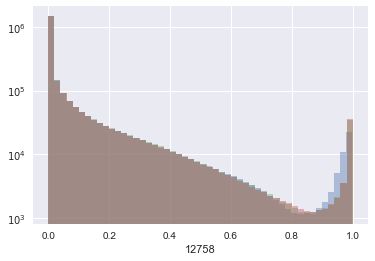

In [48]:
sns.distplot(t['1313'], kde=False)
sns.distplot(t ['new'], kde=False)
sns.distplot(t ['12758'], kde=False)
plt.yscale('log')

In [32]:
import pandas as pd
import numpy as np
import datetime
import os
import pickle

import warnings
warnings.filterwarnings('ignore')

%pylab inline
import matplotlib.pylab as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split, GroupKFold, KFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler

from scipy.sparse import csr_matrix, coo_matrix,hstack, vstack
DATA_PATH = 'data/'

import multiprocessing as mp
NUM_CORES = 4
def apply_parallel(df, my_func):
    df_splitted = np.array_split(df, NUM_CORES)
    pool = mp.Pool(NUM_CORES)
    result = pd.concat(pool.map(my_func, df_splitted))
    pool.close()
    pool.join()
    return result

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.
Populating the interactive namespace from numpy and matplotlib


In [37]:

n_splits = 5
iters_total = 1
ids = pd.read_csv('data/final/data_ids.csv',usecols=['graph_id'])
graph_ids_unique = ids.graph_id.unique()
    
for iter_num in range(iters_total):
    kf = KFold(n_splits=n_splits, shuffle=True)
    for train_graphs, test_graphs  in kf.split(graph_ids_unique):
        train_ind = ids[ids.graph_id.isin(graph_ids_unique[train_graphs])].index.values
        test_ind  = ids[ids.graph_id.isin(graph_ids_unique[test_graphs ])].index.values
            
        if True: # add validation set
            kf_valid = KFold(n_splits=7, shuffle=True)
            graph_ids_train = graph_ids_unique[train_graphs]
            train_graphs, valid_graphs = list(kf_valid.split(graph_ids_train))[0]
            train_ind = ids[ids.graph_id.isin(graph_ids_train[train_graphs])].index.values
            valid_ind = ids[ids.graph_id.isin(graph_ids_train[valid_graphs])].index.values
        print (train_ind[:15])
        print (valid_ind[:15])
        print (test_ind[:15])
        print ()


[ 0  2  4  6  7  8  9 10 11 12 15 16 17 18 19]
[  3  13  28  29  31  54  59  71  76  78  88  93  94 100 103]
[ 1  5 14 24 26 27 38 39 40 43 49 51 53 58 67]

[ 2  4  5  6  7  8 10 11 12 13 14 15 17 19 20]
[ 1  3 18 23 27 29 37 49 63 64 67 71 75 95 96]
[ 0  9 16 22 25 28 31 34 35 44 50 52 55 56 59]

[ 0  1  2  4  5  6  7  8  9 10 12 13 14 16 17]
[ 31  59  68  78 115 120 122 125 136 137 142 143 158 159 165]
[ 3 11 15 23 29 30 41 42 45 46 48 73 75 82 85]

[ 0  1  3  5  7  8  9 11 13 16 19 20 21 22 23]
[ 14  15  28  44  45  51  59  63  81  90  92  94  96 101 103]
[ 2  4  6 10 12 17 18 47 64 65 66 71 72 76 77]

[ 0  1  2  3  4  5  6  9 10 11 12 14 15 16 17]
[ 23  24  26  30  38  42  52  58  59  60  64  65  67 107 111]
[ 7  8 13 19 20 21 32 33 36 37 54 57 61 63 74]



In [40]:
gtrain = ids.iloc[train_ind].graph_id.unique()
gvalid = ids.iloc[valid_ind].graph_id.unique()
gtest = ids.iloc[test_ind].graph_id.unique()

In [39]:
gtrain

array([     1,      3,      5, ..., 535856, 535862, 535864])

In [41]:
gvalid

array([    47,     49,     53, ..., 535815, 535836, 535868])